In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
import mlp_mixer_pytorch
import mlp_shaker_flat

In [7]:
import train_simple

In [6]:
# bs_train, bs_test = 64, 128
bs_train, bs_test = 512, 1024
transform = transforms.Compose([
#     transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

ds_train = torchvision.datasets.CIFAR10('~/datasets/cifar10', train=True, transform=transform)
ds_test = torchvision.datasets.CIFAR10('~/datasets/cifar10', train=False, transform=transform)
dl_train = DataLoader(ds_train, batch_size=bs_train, shuffle=True, num_workers=16)
dl_test = DataLoader(ds_test, batch_size=bs_test, shuffle=True, num_workers=16)
n_classes = len(ds_train.classes)
bs, c, h, w = input_shape = next(iter(dl_train))[0].shape

In [16]:
mixer = mlp_shaker_flat.ViMixer(image_size=32, channels=3, patch_size=4, 
                                dim=4*4*3, depth=16, num_classes=10)

In [17]:
train_simple.train_net(mixer, dl_train, dl_test=dl_test, n_epochs=10, lr=0.01,
                       device='cuda:0', tqdm=tqdm, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Average Loss: 2.307, Accuracy: 0.120%
{'loss': 2.3066243953704832, 'accuracy': 0.1203}


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Average Loss: 1.707, Accuracy: 0.388%
{'loss': 1.7067187870025635, 'accuracy': 0.388}


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Average Loss: 1.517, Accuracy: 0.447%
{'loss': 1.5172109888076781, 'accuracy': 0.4469}


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Average Loss: 1.412, Accuracy: 0.491%
{'loss': 1.4120927326202393, 'accuracy': 0.4914}


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Average Loss: 1.342, Accuracy: 0.511%
{'loss': 1.3424203359603881, 'accuracy': 0.5111}


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Average Loss: 1.314, Accuracy: 0.528%
{'loss': 1.3138240463256836, 'accuracy': 0.5278}


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Average Loss: 1.304, Accuracy: 0.532%
{'loss': 1.3044745365142822, 'accuracy': 0.5316}


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Average Loss: 1.300, Accuracy: 0.534%
{'loss': 1.2999618438720704, 'accuracy': 0.5343}


  0%|          | 0/98 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
mixer[0:3]

Sequential(
  (0): Rearrange('b c (nph psh) (npw psw) -> b (nph npw) (psh psw c)', psh=4, psw=4)
  (1): Linear(in_features=48, out_features=48, bias=True)
  (2): MLPFlatShaker(
    (mix_dims): ModuleList(
      (0): PreNormResidual(
        (fn): Sequential(
          (0): DimLinear(64, 64, kernel_size=(1,), stride=(1,))
        )
        (norm): DimLayerNorm((1, 48), eps=1e-05, elementwise_affine=True)
      )
      (1): PreNormResidual(
        (fn): Sequential(
          (0): DimLinear(48, 48, kernel_size=(1,), stride=(1,))
        )
        (norm): DimLayerNorm((1, 48), eps=1e-05, elementwise_affine=True)
      )
      (2): PreNormResidual(
        (fn): Sequential(
          (0): DimLinear(64, 64, kernel_size=(1,), stride=(1,))
        )
        (norm): DimLayerNorm((1, 48), eps=1e-05, elementwise_affine=True)
      )
      (3): PreNormResidual(
        (fn): Sequential(
          (0): DimLinear(48, 48, kernel_size=(1,), stride=(1,))
        )
        (norm): DimLayerNorm((1, 48),

In [62]:
device = 'cuda:0'
x, y = next(iter(dl_train))
x, y = x.to(device), y.to(device)



In [64]:
mixer[2].mix_dims[0]

PreNormResidual(
  (fn): Sequential(
    (0): DimLinear(64, 64, kernel_size=(1,), stride=(1,))
  )
  (norm): DimLayerNorm((1, 48), eps=1e-05, elementwise_affine=True)
)

In [88]:
64*64

4096

In [91]:
8*8*2*10

1280

In [100]:
xt = mixer[0:2](x).detach()

y_mix = mixer[2].mix_dims[0](xt).detach()

mini_shaker = mlp_shaker_flat.MLPFlatShaker(shape=(8, 8, 48), dims_to_mix=[0, 1]*4)
print(util.count_params(mini_shaker))
# mini_shaker = mlp_shaker_flat.MLPFlatShaker(shape=(64, 48), dims_to_mix=[0]*1)
print(util.count_params(mini_shaker))
mini_shaker.to(device)
opt = torch.optim.Adam(mini_shaker.parameters(), lr=1e-2)
for i in range(1000):
    y_shake = mini_shaker(xt)
    loss = (y_mix-y_shake).pow(2).mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i%50==0:
        print((y_mix-y_shake).pow(2).mean())


1344
1344
tensor(12.5140, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3741, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4519, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6545, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4317, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3093, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2251, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1619, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0913, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0107, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9216, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8498, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.7968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.7495, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.7007, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.6388, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.5662, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.5040, devic

In [24]:
torch.manual_seed(0)
np.random.seed(0)

def create_linear_dataset(N, M, n_samp_train, n_samp_test):
    M = torch.randn(M, N)
    X = torch.randn(n_samp_train+n_samp_test, N)
    Y = X@M.T
    X_train, X_test = X.split([n_samp_train, n_samp_test])
    Y_train, Y_test = Y.split([n_samp_train, n_samp_test])
    return X_train, Y_train, X_test, Y_test

def create_linearbot_dataset(N, M, bottleneck, n_samp_train, n_samp_test):
    M1 = torch.randn(bottleneck, N)
    M2 = torch.randn(M, bottleneck)
    X = torch.randn(n_samp_train+n_samp_test, N)
    Y = (X@M1.T)@M2.T
    X_train, X_test = X.split([n_samp_train, n_samp_test])
    Y_train, Y_test = Y.split([n_samp_train, n_samp_test])
    return X_train, Y_train, X_test, Y_test

def create_nonlinear_dataset(N, M, n_samp_train, n_samp_test):
    M = torch.randn(M, N)
    X = torch.randn(n_samp_train+n_samp_test, N)
    Y = (X.sin()@M.T).tanh()
    X_train, X_test = X.split([n_samp_train, n_samp_test])
    Y_train, Y_test = Y.split([n_samp_train, n_samp_test])
    return X_train, Y_train, X_test, Y_test
    

# X_train, Y_train, X_test, Y_test = create_linear_dataset(16, 16, 9999, 999)
X_train, Y_train, X_test, Y_test = create_linearbot_dataset(16, 16, 4, 9999, 999)
# X_train, Y_train, X_test, Y_test = create_nonlinear_dataset(100, 100, 9999, 999)

In [25]:
def evaluate(net, train='False', device=None, bs=300, verbose=False):
    net = net.to(device)
    losses = []
    if train:
        X, Y = X_train, Y_train
    else:
        X, Y = X_test, Y_test
#     for X_batch, Y_batch in tqdm(zip(X.split(bs), Y.split(bs)), leave=False, total=math.ceil(len(X)/bs)):
    for X_batch, Y_batch in zip(X.split(bs), Y.split(bs)):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        Y_batch_pred = net(X_batch)
        loss = (Y_batch_pred-Y_batch).pow(2.).mean().item()
        losses.append(loss)
    losses = np.mean(losses)
    if verbose:
        print(f'Average Loss: {losses}')
    return {'loss': losses}
    
def train(net, lr=1e-2, device=None, n_epochs=10, bs=300):
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    losses_train, losses_test = [], []
    loop = tqdm(range(n_epochs))
    for epoch_idx in loop:
#         for X_batch, Y_batch in tqdm(zip(X_train.split(bs), Y_train.split(bs)), leave=False, total=math.ceil(len(X_train)/bs)):
        for X_batch, Y_batch in zip(X_train.split(bs), Y_train.split(bs)):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_batch_pred = net(X_batch)
            loss = (Y_batch_pred-Y_batch).pow(2.).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
        losses_train.append(evaluate(net, train=True, bs=bs, device=device)['loss'])
        losses_test.append(evaluate(net, train=False, bs=bs, device=device)['loss'])
        loop.set_postfix({'train loss': losses_train[-1], 'test loss': losses_train[-1]})
    plt.plot(losses_train, label='training loss')
    plt.plot(losses_test, label='testing loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()

In [26]:
from mlp_mixer_pytorch import HeadlessMLPMixer

# params:  272


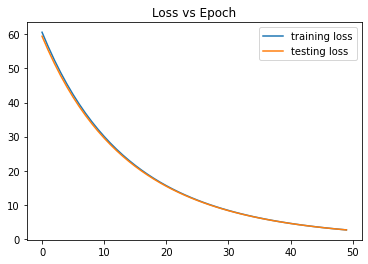

In [27]:
net = nn.Linear(16, 16)
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=50)

# params:  5760


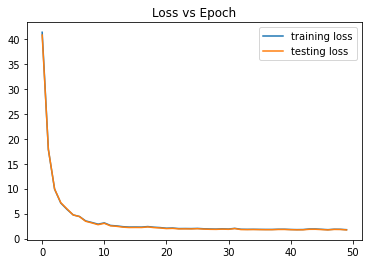

In [28]:
net = mlp_shaker_flat.MLPFlatShaker([16], [0]*10, )
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=50)

# params:  480


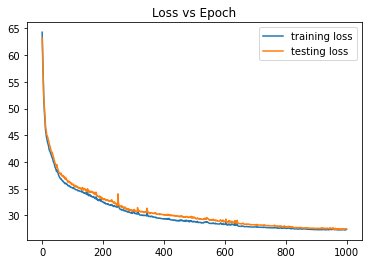

In [29]:
net = mlp_shaker_flat.MLPFlatShaker([4, 4], [0, 1]*5, ).to(device)
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=1000)

In [23]:
net = HeadlessMLPMixer(4, 4, depth=10)
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=1000)

# params:  3120


KeyboardInterrupt: 

In [4]:
import dim_models

In [5]:
net = nn.Linear(100, 100).to(device)

In [12]:
%%timeit
net(torch.randn(500, 200, 100).to(device))

79.4 ms ± 576 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
net = dim_models.DimLinear(100, 100, shape=[200, 100], dim_to_mix=1).to(device)

In [14]:
%%timeit
net(torch.randn(500, 200, 100).to(device))

79.2 ms ± 766 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
net = dim_models.DimLinear(100, 100, shape=[100, 200], dim_to_mix=0).to(device)

In [16]:
%%timeit
net(torch.randn(500, 100, 200).to(device))

78.8 ms ± 803 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
a = torch.randn(7777, 100).to(device)
b = torch.randn(100, 90).to(device)

In [48]:
%%timeit
c = a@b

45.8 µs ± 299 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [49]:
%%timeit
c = (a[..., None]*b).sum(dim=-2)

2.34 ms ± 4.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [50]:
a = torch.randn(7777, 100, 1).to(device)
b = torch.randn(7777, 100, 90).to(device)

In [51]:
%%timeit
c = (a*b).sum(dim=-2)

2.3 ms ± 206 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
